<a href="https://colab.research.google.com/github/AarinSalot/182-stuff/blob/main/EncoderDecoderBridge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
from transformers import MambaConfig, Mamba2Model, Mamba2ForCausalLM, AutoModel, AutoTokenizer
from IPython.display import display
from transformers import ViTConfig, ViTModel, get_scheduler
from tqdm import tqdm


In [2]:
!pip install datasets

In [3]:
# Initializing a ViT vit-base-patch16-224 style configuration
configuration = ViTConfig()

# Initializing a model (with random weights) from the vit-base-patch16-224 style configuration
model = ViTModel(configuration)

# Accessing the model configuration
configuration = model.config
print(model)

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTOutput(
          (d

In [4]:
from huggingface_hub import login
login()
from datasets import load_dataset
import itertools
from transformers import ViTImageProcessorFast, ViTForImageClassification
from PIL import Image
import requests
from io import BytesIO
import time

In [5]:

train_ds_laion_iter = load_dataset("laion/laion400m", split='train', streaming=True)
batches = [list(itertools.islice(train_ds_laion_iter, 1)) for _ in range(1)]

Resolving data files:   0%|          | 0/128 [00:00<?, ?it/s]

In [6]:
# image processor & model
processor = ViTImageProcessorFast.from_pretrained('google/vit-base-patch16-224')
tf_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

mamba_tokenizer = AutoTokenizer.from_pretrained("AntonV/mamba2-130m-hf")
mamba_model = Mamba2Model.from_pretrained("AntonV/mamba2-130m-hf")
tok_model = Mamba2ForCausalLM.from_pretrained("AntonV/mamba2-130m-hf")


The fast path is not available because on of `(selective_state_update, causal_conv1d_fn, causal_conv1d_update)` is None. Falling back to the naive implementation. To install follow https://github.com/state-spaces/mamba/#installation and https://github.com/Dao-AILab/causal-conv1d


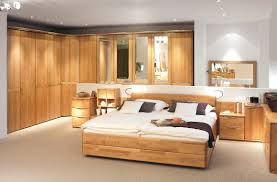

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [7]:
def load_and_process_images(urls):
  imgs = []
  for url in urls:
    try:
        response = requests.get(url)
        if response.status_code == 200 and 'image' in response.headers['Content-Type']:
            img = Image.open(BytesIO(response.content)).convert("RGB")
            display(img)
            imgs.append(img)
        else:
            print(f"Skipped non-image URL: {url}")
    except Exception as e:
        print(f"Error loading {url}: {e}")
  return processor(images=imgs, do_resize=True, size=224, default_to_square=True, return_tensors="pt")['pixel_values']


def convert_caption_to_embedding_space(tokenizer, captions):
  return tokenizer(captions, return_tensors="pt", padding=True, truncation=True)['input_ids']

def set_fake_dataloader(batches):
  res = []
  for batch in batches:
    urls = []
    captions = []
    for item in batch:
      urls.append(item['url'])
      captions.append(item['caption'])
    inputs = load_and_process_images(urls)
    embedding_ids = convert_caption_to_embedding_space(mamba_tokenizer, captions)
    batch_info = {
      'pixel_values':inputs,
      'captions': embedding_ids
    }
    res.append(batch_info)
  return res


train_dataloader = set_fake_dataloader(batches)
#rint(train_dataloader[0])




In [17]:
class FusionModel(nn.Module):
    def __init__(self, encoder, decoder, head, pad_token_id, loss=None, hidden_dim=768, bridge_dim=768):
        super().__init__()
        self.encoder = encoder   # e.g., ViT or BERT (frozen)
        self.decoder = decoder   # e.g., Mamba2Model or Mamba2ForCausalLM (frozen or partially trainable)
        self.head = head         # Mamba2CausalLM, we're going to use it's head to get output logits
        self.pad_token_id = pad_token_id
        self.loss = loss

        # 2-layer MLP bridge: Transformer → Mamba
        self.bridge = nn.Sequential(
            nn.LayerNorm(hidden_dim),           # normalize TF output (per token)
            nn.Linear(hidden_dim, bridge_dim),  # project to bridge space
            nn.GELU(),                          # non-linearity
            nn.Linear(bridge_dim, hidden_dim),  # project back to match Mamba input
            nn.LayerNorm(hidden_dim)            # stabilize for Mamba
        )

    def train(self, mode: bool = True):
        super().train(mode)  # sets self + submodules to train/eval

        # # OPTIONAL: freeze encoder/decoder even when model.train(True)
        # self.encoder.eval()  # encoder stays frozen & in eval mode
        # for param in self.encoder.parameters():
        #     param.requires_grad = False

        # self.decoder.eval()  # decoder stays frozen & in eval mode
        # for param in self.decoder.parameters():
        #     param.requires_grad = False
        return self


    def forward(self, x=None, labels=None, **kwargs):
        # Get transformer output
        # with torch.no_grad():  # optionally freeze encoder
        print(x.shape)
        encoder_output = self.encoder(x, output_hidden_states=True)
        # Bridge projection
        s = encoder_output.hidden_states[-1]
        print(s.shape)
        bridged = self.bridge(s)  # shape: [B, T, D]
        # Pass to Mamba decoder
        print(bridged.shape)
        decoder_output = self.decoder(inputs_embeds=bridged, **kwargs)
        print(decoder_output.last_hidden_state.shape)
        # Pass to the head to turn into logits (that we'll apply loss on)
        logits = self.head.lm_head(decoder_output.last_hidden_state)

        res = {"logits": logits}

        # Optionally compute loss
        loss = None
        if labels is not None:
            print(labels.shape)
            print(logits.shape)
            loss = self.loss(
                logits,
                labels,
                ignore_index=self.pad_token_id  # or tokenizer.pad_token_id
            )
            res['loss'] = loss
        return res


In [18]:
# Training loop

epochs = 1
train_dataloader = train_dataloader

model = FusionModel(encoder=tf_model, decoder=mamba_model, head=tok_model, pad_token_id=mamba_tokenizer.pad_token_id, loss=F.cross_entropy)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

num_training_steps = epochs * len(train_dataloader)
# lr_scheduler = get_scheduler(
#     "linear",
#     optimizer=optimizer,
#     num_warmup_steps=0,
#     num_training_steps=num_training_steps,
# )


# train_dataloader = load_dataset("tavish-mishra/my_image_captioning_dataset", split='train[:10%]')


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

progress_bar = tqdm(range(num_training_steps))


# With padding — but using ignore_index to ignore the padded tokens during loss computation.

for epoch in range(epochs):
  for batch in train_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}

    outputs = model(x=batch['pixel_values'], labels=batch['captions'])
    loss = outputs['loss']
    loss.backward()

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)














  0%|          | 0/1 [00:13<?, ?it/s]


torch.Size([1, 3, 224, 224])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 11])
torch.Size([1, 197, 50288])


RuntimeError: Expected target size [1, 50288], got [1, 11]

In [ ]:
# Testing TF functionality: Predicting the top 10 classes
logits = outputs.logits
probs = F.softmax(logits, dim=-1)
top_probs, top_indices = torch.topk(probs, k=10)

print("Top 10 predicted classes:")
for i in range(len(images)):
  for j in range(10):
      idx = top_indices[i][j].item() if top_indices.dim() == 2 else top_indices[i].item()
      prob = top_probs[i][j].item() if top_probs.dim() == 2 else top_probs[i].item()
      label = model.config.id2label.get(idx, f"Class {idx}")
      print(f"{i+1}. {label} ({prob:.4f})")
  print()

In [ ]:
'''
Tokens are laid out like this:

[
  [CLS],  # index 0
  patch(0,0), patch(0,1), ..., patch(0,13),
  patch(1,0), patch(1,1), ..., patch(1,13),
  ...
  patch(13,13)  # index 196
]

'''

print(outputs.__dict__.keys())
# shape of the models outputs (ex: z1...zn-1, z(cls)) for a singular image
print(outputs.hidden_states[-1].shape)

In [ ]:
# Restructure the image.

z = outputs.hidden_states[-1]
batch_size, num_z_values, embedding_dim = z.shape

num_patches = num_z_values - 1
grid_dim = round(num_patches ** 0.5)

z_cls = z[:,0:1,:]
z_image = z[:,1:,:].view(batch_size, grid_dim, grid_dim, embedding_dim)

print(z_image.shape)
print(z_cls.shape)

In [ ]:
# TODO: come back to zigzags later


# def horizontal_zigzag_forward(z):
#     # Left to right zigzag across rows
#     return torch.stack([
#         row if i % 2 == 0 else torch.flip(row, dims=[0])
#         for i, row in enumerate(z)
#     ])

# def horizontal_zigzag_backward(z):
#     # Right to left zigzag across rows (reverse direction of above)
#     return torch.stack([
#         torch.flip(row, dims=[0]) if i % 2 == 0 else row
#         for i, row in enumerate(torch.flip(z, dims=[0]))
#     ])

# def vertical_zigzag_downward(z):
#     # Top to bottom zigzag across columns
#     return torch.stack([
#         col if i % 2 == 0 else torch.flip(col, dims=[0])
#         for i, col in enumerate(z.permute(1, 0, 2))
#     ]).permute(1, 0, 2)

# def vertical_zigzag_upward(z):
#     # Bottom to top zigzag across columns (reverse direction of above)
#     return torch.stack([
#         torch.flip(col, dims=[0]) if i % 2 == 0 else col
#         for i, col in enumerate(torch.flip(z.permute(1, 0, 2), dims=[0]))
#     ]).permute(1, 0, 2)

In [ ]:
# z1 = horizontal_zigzag_forward(z_image).reshape(batch_size, -1, embedding_dim)
# z2 = horizontal_zigzag_backward(z_image).reshape(batch_size, -1, embedding_dim)
# z3 = vertical_zigzag_downward(z_image).reshape(batch_size, -1, embedding_dim)
# z4 = vertical_zigzag_upward(z_image).reshape(batch_size, -1, embedding_dim)


In [ ]:
# figure out how get z_cls back into the mix (z_cls is a summary with global context over the image!!)
# z1_cls = torch.cat([z_cls, z1], dim=1)
# z2_cls = torch.cat([z_cls, z2], dim=1)
# z3_cls = torch.cat([z_cls, z3], dim=1)
# z4_cls = torch.cat([z_cls, z4], dim=1)

In [ ]:
# combine and normalize
# combined = z + z1_cls + z2_cls + z3_cls + z4_cls
combined = z

In [ ]:
print(combined.shape)

In [ ]:
# TODO: run a linear layer + normalize
# Feed into the model directly.



print(model)

In [ ]:
prompts = ["CAT, BAT, PAT, ___", "ONE, TWO, THREE, ___", "TESTING, TRAINING, ..."]
inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, return_attention_mask=True)
# input_ids = tokenized_input["input_ids"]
# attention_mask = tokenized_input["attention_mask"]
embeddings = model.embeddings(inputs["input_ids"])
print(embeddings.shape)
embeddings = combined

In [ ]:
output = model(inputs_embeds=embeddings)

In [ ]:
# Use the lm_head to get logits from hidden states
# we can use the decoder from the Mamba2ForCausalLM to get some string. Model already pretrained on
# this embedding space so it makes sense to keep this.

# convert the expect caption to vector and run cosine similarity on the output of the model
logits = model_for_tok.lm_head(output.last_hidden_state)
token_ids = logits.argmax(dim=-1)
text = tokenizer.batch_decode(token_ids, skip_special_tokens=True)
print(len(text))
print(text)

In [ ]:
"""
Trial 1: ['- and, and, and\n', '_\n, THREE, FOUR\n', '_ THE\nINING, AND\n']

trial 2: ['\nAL the, BAT, and\n', '\n OF\n, THREE, FOUR\n', '_ THE\nINING, AND\n']


I noticed tha


"""

In [10]:
# Garbage cleanup
import gc; gc.collect()

38

In [ ]:
# del images, outputs, logits, probs, top_probs, top_indices
# del z, z_cls, z_image, combined, logits,
del token_ids, text, embeddings, inputs